In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gc
%matplotlib inline 
np.random.seed(43)

In [3]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
DIR = "~/.kaggle/competitions/competitive-data-science-final-project/"
sales = pd.read_csv(DIR+'sales_train_processed.csv')
shops = pd.read_csv(DIR+'shops.csv')
items = pd.read_csv(DIR+'items.csv')
item_cats = pd.read_csv(DIR+'item_categories.csv')
tests = pd.read_csv(DIR+'test.csv.gz').drop("ID",axis=1)
samples = pd.read_csv(DIR+'sample_submission.csv.gz')

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday
0,2013-02-15,1,0,30,265.0,2.0,4
1,2013-02-16,1,0,30,265.0,9.0,5
2,2013-02-17,1,0,30,265.0,4.0,6
3,2013-02-18,1,0,30,265.0,4.0,0
4,2013-02-20,1,0,30,265.0,2.0,2


In [5]:
def std_rate(arr):
    return np.std(arr) / (np.mean(arr)+10e-5)

In [6]:
def divmean(arr):
    return np.mean(arr)

In [7]:
# Create "grid" with columns
# date block num means the order of month
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_sum':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_sum':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: vars
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_var':'var'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: vars
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_var':'var'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: vars
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_max':'max'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: vars
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_max':'max'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates: vars
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_min':'min'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: vars
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_min':'min'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

all_data['target_shop_maxmin'] = all_data['target_shop_max'] - all_data['target_shop_min'] 
all_data['target_item_maxmin'] = all_data['target_item_max'] - all_data['target_item_min'] 

gb = sales[sales.item_cnt_day==0].groupby(index_cols,as_index=False).size().reset_index()
gb.columns = [col if col != 0 else 'count_zero' for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates: vars
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_med':'median'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates: vars
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item_med':'median'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

#gb = sales[sales.item_cnt_day==0].groupby(index_cols,as_index=False).size().reset_index()
#pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

gb = sales.groupby(index_cols,as_index=False)['item_price'].std().reset_index()
gb.columns = [col if col != gb.columns.values[-1] else 'price_std' for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

gb = sales.groupby(index_cols,as_index=False)['item_price'].mean().reset_index()
gb.columns = [col if col != gb.columns.values[-1] else 'price_mean' for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)
all_data['price_umean'] = all_data['price_mean'] - (all_data['price_mean'] // 100) * 100

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [8]:
#all_data.target_item_sum = np.log1p(all_data.target_item_sum)
#all_data.target_shop_sum = np.log1p(all_data.target_shop_sum)

In [9]:
#all_data.target_item_var = np.log1p(all_data.target_item_var)
#all_data.target_shop_var = np.log1p(all_data.target_shop_var)

In [10]:
# mean encoding
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()
all_data['item_target_enc'] = cumsum /cumcnt
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

In [11]:
# mean encoding
#col='target_item_sum'
#cumsum = all_data.groupby('item_id')[col].cumsum() - all_data[col]
#cumcnt = all_data.groupby('item_id')[col].cumcount()
#all_data[col+'_enc'] = cumsum /cumcnt
#all_data[col+'_enc'].fillna(all_data[col+'_enc'].mean(), inplace=True) 

In [12]:
# mean encoding
#col='target_item_var'
#cumsum = all_data.groupby('item_id')[col].cumsum() - all_data[col]
#cumcnt = all_data.groupby('item_id')[col].cumcount()
#all_data[col+'_enc'] = cumsum /cumcnt
#all_data[col+'_enc'].fillna(all_data[col+'_enc'].mean(), inplace=True) 

In [13]:
# mean encoding
cumsum = all_data.groupby('shop_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('shop_id')['target'].cumcount()
all_data['shop_target_enc'] = cumsum /cumcnt
all_data['shop_target_enc'].fillna(all_data['shop_target_enc'].mean(), inplace=True) 

In [14]:
# mean encoding
#col='target_shop_sum'
#cumsum = all_data.groupby('shop_id')[col].cumsum() - all_data[col]
#cumcnt = all_data.groupby('shop_id')[col].cumcount()
#all_data[col+'_enc'] = cumsum /cumcnt
#all_data[col+'_enc'].fillna(all_data[col+'_enc'].mean(), inplace=True) 

In [15]:
# mean encoding
#col='target_shop_var'
#cumsum = all_data.groupby('shop_id')[col].cumsum() - all_data[col]
#cumcnt = all_data.groupby('shop_id')[col].cumcount()
#all_data[col+'_enc'] = cumsum /cumcnt
#all_data[col+'_enc'].fillna(all_data[col+'_enc'].mean(), inplace=True) 

In [16]:
# concat test data
tests["date_block_num"] = 34
tests["target"] = np.nan
tests["target_shop"] = np.nan
tests["target_item"] = np.nan
all_data = pd.concat([all_data, tests],axis=0)

In [17]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [18]:
from datetime import datetime as dt

In [19]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 

# We will drop these at fitting stage
# for avoid dataleakage
# to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']
#to_drop_cols = to_drop_cols + [i+'_log' for i in to_drop_cols]

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [20]:
#  weekday features
a = sales.groupby(["date", "date_block_num", "weekday"]).count().reset_index()[["date", 
                                                                            "date_block_num", "weekday"]].groupby(["date_block_num","weekday"]).size().reset_index()
submit_time = pd.DataFrame([dt(2015, 11, i) for i in range(1,31)],columns=["dt"])
submit_time["weekday"] = submit_time.dt.apply(lambda x: x.weekday())
submit_time["date_block_num"] = 34
submit_time = submit_time.groupby(["date_block_num","weekday"]).size().reset_index()
a = pd.concat([a,submit_time],axis=0)

b = pd.get_dummies(a["weekday"])
b.columns=["weekday_"+str(i) for i in range(7)]
b = b*np.tile(a[0].values.reshape(-1, 1),7)
a = pd.concat([a,b],axis=1).drop(["weekday", 0], axis=1).groupby("date_block_num").sum().reset_index()

all_data = pd.merge(all_data, a, on='date_block_num',how="left")

In [21]:
#all_data["month"] = all_data.date_block_num.apply(lambda x: (x + 1) % 12 +1)

In [22]:
to_drop_cols

['target_shop',
 'target_shop_med',
 'target_shop_max',
 'count_zero',
 'target_item_med',
 'target_shop_sum',
 'price_std',
 'target_shop_maxmin',
 'target_shop_min',
 'price_umean',
 'target_item',
 'target_item_var',
 'price_mean',
 'shop_target_enc',
 'target_item_max',
 'index_y',
 'target_shop_var',
 'item_target_enc',
 'target_item_maxmin',
 'target_item_min',
 'target',
 'index_x',
 'target_item_sum',
 'date_block_num']

### additional features

In [23]:
# lag rate value
lag_rate_columns = [
    'item_target_enc_lag',
    'shop_target_enc_lag',
    'target_lag',
    'target_item_lag',
    'target_item_sum_lag',
    'target_item_var_lag',
    'target_shop_lag',
    'target_shop_sum_lag',
    'target_shop_var_lag',
]

for line in lag_rate_columns:
    all_data[line+'_rate12'] = all_data[line+'_1'] / (all_data[line+'_2']+10e5)
    all_data.loc[all_data[all_data[line+'_rate12']>10e3].index, line+'_rate12'] = 0

In [24]:
#all_data["holiday"] = all_data["weekday_5"] + all_data["weekday_6"]

In [25]:
# NMF
#import nimfa 
#nmf = nimfa.Nmf(all_data[all_data['date_block_num'] < 34].values, method= 'lsnmf', rank = 10,  max_iter = 100)
#nmf_fit = nmf()
#nmf_mat = nmf_fit.basis
#nmf_mat

In [26]:
# t-sne
#from sklearn.manifold import TSNE
# too long
#tsne = TSNE(n_components=2, random_state=0).fit_transform(all_data[all_data['date_block_num'] < 34].values)

### train, validate scheme

In [25]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max() # for validation data: last block is test data to predict
print('Test `date_block_num` is %d' % last_block)

test_rate = 0.25
train_rate = 1 - test_rate
dates_train = dates[dates <  (last_block - 2)]
dates_val = dates[dates == (last_block - 2)]
dates_test = dates[dates == (last_block - 1)]
dates_submit  = dates[dates == last_block]

X_train = all_data.loc[dates <  (last_block - 2)].drop(to_drop_cols, axis=1)
X_val = all_data.loc[dates == (last_block - 2)].drop(to_drop_cols, axis=1)
X_test = all_data.loc[dates == (last_block - 1)].drop(to_drop_cols, axis=1)
X_train_submit = all_data.loc[dates < last_block].drop(to_drop_cols, axis=1)
X_train_test = all_data.loc[dates < (last_block-1)].drop(to_drop_cols, axis=1)
X_submit =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  (last_block - 2), 'target'].values
y_val = all_data.loc[dates == (last_block - 2), 'target'].values
y_test = all_data.loc[dates == (last_block - 1), 'target'].values
y_train_submit = all_data.loc[dates < last_block, 'target'].values
y_train_test = all_data.loc[dates < (last_block-1), 'target'].values
y_submit =  all_data.loc[dates == last_block, 'target'].values

Test `date_block_num` is 34


### quick feature selection

In [29]:
gbm_reg = lgb.LGBMRegressor()
gbm_reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [30]:
# print feature importance rate
features = gbm_reg.feature_importances_
selected = []
features_ind  = np.argsort(features)[::-1]

print('Feature Importances:')
for i, feat in enumerate(X_submit.columns):
    print('\t{0:10s} : {1:>.2f}'.format(feat, features[features_ind[i]]))
    #if i < 0.6*len(features):
    if features[i]>0: 
        selected.append(feat)

Feature Importances:
	item_id    : 198.00
	shop_id    : 137.00
	count_zero_lag_1 : 126.00
	index_x_lag_1 : 124.00
	index_y_lag_1 : 118.00
	item_target_enc_lag_1 : 92.00
	price_mean_lag_1 : 84.00
	price_std_lag_1 : 75.00
	price_umean_lag_1 : 70.00
	shop_target_enc_lag_1 : 66.00
	target_lag_1 : 56.00
	target_item_lag_1 : 52.00
	target_item_max_lag_1 : 52.00
	target_item_maxmin_lag_1 : 52.00
	target_item_med_lag_1 : 50.00
	target_item_min_lag_1 : 50.00
	target_item_sum_lag_1 : 49.00
	target_item_sum_enc_lag_1 : 47.00
	target_item_var_lag_1 : 46.00
	target_shop_lag_1 : 45.00
	target_shop_max_lag_1 : 45.00
	target_shop_maxmin_lag_1 : 45.00
	target_shop_med_lag_1 : 41.00
	target_shop_min_lag_1 : 39.00
	target_shop_sum_lag_1 : 39.00
	target_shop_var_lag_1 : 36.00
	count_zero_lag_2 : 33.00
	index_x_lag_2 : 32.00
	index_y_lag_2 : 30.00
	item_target_enc_lag_2 : 30.00
	price_mean_lag_2 : 29.00
	price_std_lag_2 : 28.00
	price_umean_lag_2 : 28.00
	shop_target_enc_lag_2 : 27.00
	target_lag_2 : 26.00

In [29]:
selected = X_train.columns
lgb_params = {
               'max_depth': 10,
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 150, 
               'bagging_fraction': 0.5, 
               'learning_rate': 0.015, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**8,
               'bagging_freq':1,
               'lambda_l2':1,    
               'verbose':0
              }

lgb_train = lgb.Dataset(X_train[selected], y_train)
lgb_eval = lgb.Dataset(X_val[selected], y_val, reference=lgb_train)

model = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=200,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            )
pred = model.predict(X_val[selected], num_iteration=model.best_iteration)

print('Test R-squared for LightGBM is %f' % r2_score(y_val.clip(0,20), pred.clip(0,20)))
#print('Train RMSE is %f' % np.sqrt(mean_squared_error(y_train.clip(0,20), 
#                                                     model.predict(X_train[selected], num_iteration=model.best_iteration).clip(0,20))))
print('Valid RMSE is %f' % np.sqrt(mean_squared_error(y_val.clip(0,20), pred.clip(0,20))))
print('Test RMSE is %f' % np.sqrt(mean_squared_error(y_test.clip(0,20), 
                                                     model.predict(X_test[selected], num_iteration=model.best_iteration).clip(0,20))))

[1]	valid_0's rmse: 6.83629
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 6.82428
[3]	valid_0's rmse: 6.81319
[4]	valid_0's rmse: 6.8015
[5]	valid_0's rmse: 6.7906
[6]	valid_0's rmse: 6.78136
[7]	valid_0's rmse: 6.77024
[8]	valid_0's rmse: 6.75996
[9]	valid_0's rmse: 6.75016
[10]	valid_0's rmse: 6.74063
[11]	valid_0's rmse: 6.7311
[12]	valid_0's rmse: 6.72536
[13]	valid_0's rmse: 6.71598
[14]	valid_0's rmse: 6.7095
[15]	valid_0's rmse: 6.70072
[16]	valid_0's rmse: 6.69366
[17]	valid_0's rmse: 6.68827
[18]	valid_0's rmse: 6.67987
[19]	valid_0's rmse: 6.67165
[20]	valid_0's rmse: 6.66361
[21]	valid_0's rmse: 6.65549
[22]	valid_0's rmse: 6.64885
[23]	valid_0's rmse: 6.642
[24]	valid_0's rmse: 6.6359
[25]	valid_0's rmse: 6.62831
[26]	valid_0's rmse: 6.62225
[27]	valid_0's rmse: 6.61784
[28]	valid_0's rmse: 6.61296
[29]	valid_0's rmse: 6.6056
[30]	valid_0's rmse: 6.59976
[31]	valid_0's rmse: 6.594
[32]	valid_0's rmse: 6.5878
[33]	valid_0's rmse: 6.58193
[

Test R-squared for LightGBM is 0.371710
Train RMSE is 0.882395
Valid RMSE is 0.914881
Test RMSE is 0.947681

Test R-squared for LightGBM is 0.371643
Train RMSE is 0.881523
Valid RMSE is 0.914930
Test RMSE is 0.945535

Test R-squared for LightGBM is 0.358352
Train RMSE is 0.892851
Valid RMSE is 0.924555
Test RMSE is 0.956555

Test R-squared for LightGBM is 0.399714
Valid RMSE is 0.894260
Test RMSE is 0.944323

Test R-squared for LightGBM is 0.398531
Valid RMSE is 0.895140
Test RMSE is 0.943773

Test R-squared for LightGBM is 0.363386
Valid RMSE is 0.920922
Test RMSE is 0.955281

Test R-squared for LightGBM is 0.357545
Valid RMSE is 0.925137
Test RMSE is 0.963359

Test R-squared for LightGBM is 0.288185
Valid RMSE is 0.973797
Test RMSE is 0.995382

Test R-squared for LightGBM is 0.326516
Valid RMSE is 0.871942
Test RMSE is 0.971040

Test R-squared for LightGBM is 0.326477
Valid RMSE is 0.871968
Test RMSE is 0.971562

Test R-squared for LightGBM is 0.321752
Valid RMSE is 0.875138
Test RMSE is 0.976434

Test R-squared for LightGBM is 0.291365
Valid RMSE is 0.971616
Test RMSE is 1.001099

In [148]:
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dropout
from keras.models import Model
from keras import backend as K

In [149]:
batch_size = 100
in_layer = Input((len(selected),))
hidden = Dense(192, activation = 'relu')(in_layer)
hidden = Dense(192, activation = 'relu')(hidden)
hidden = Dense(192, activation = 'relu')(hidden)
output = Dense(1)(hidden)

In [150]:
model = Model(input=in_layer, output=output)
model.compile(loss='mean_squared_error',
              optimizer=RMSprop())

/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [151]:
N = len(X_train) //100 * 100
hist = model.fit(X_train[selected].iloc[:N].values, y_train[:N],
                 batch_size=batch_size,
                 verbose=1,
                 nb_epoch=5,
                 )

/Users/sh-tatsuno/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/5
5968200/5968200 [==============================] - 205s - loss: 68.2617   
Epoch 2/5
3869300/5968200 [==================>...........] - ETA: 71s - loss: 7.6541

KeyboardInterrupt: 

In [152]:
model.fit?

### train for submit

In [30]:
lgb_train = lgb.Dataset(X_train_submit[selected], y_train_submit)
model = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=200,
            )

# transform submission form
submit_preds = model.predict(X_submit)
submit_cols = ["ID", "item_cnt_month"]
submit = pd.DataFrame(np.c_[np.arange(len(submit_preds)),submit_preds.clip(0.,20.)], columns=submit_cols)
submit.ID=submit.ID.astype("int")
submit.to_csv("csv/quick_lightgbm12.csv",index=None)

In [36]:
submit

,ID,item_cnt_month
0,0,0.369363
1,1,0.298394
2,2,0.537382
3,3,0.351394
4,4,0.993298
5,5,0.432844
6,6,0.613475
7,7,0.224740
8,8,0.490094
9,9,0.369438


In [11]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.253475


In [12]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.282812


In [13]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 

In [14]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [15]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

ind=0
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    X_train_level1 = X_train.loc[dates_train[dates_train<cur_block_num].index]
    y_train_level1 = y_train[dates_train[dates_train<cur_block_num].index]
    lr.fit(X_train_level1, y_train_level1)
    model = lgb.train(lgb_params, lgb.Dataset(X_train_level1, label=y_train_level1), 100)
    
    Xtr = X_train.loc[dates_train_level2[dates_train_level2==cur_block_num].index].values
    X_train_level2[ind:ind+len(Xtr),0] = lr.predict(Xtr)
    X_train_level2[ind:ind+len(Xtr),1] = model.predict(Xtr)
    ind += len(Xtr)
    

27
28
29
30
31
32


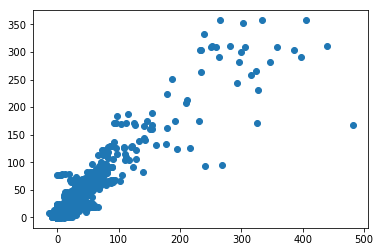

In [16]:
plt.scatter(X_train_level2[:,0],X_train_level2[:,1])

In [36]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_mix = 0
r2_alpha = 0
for alpha in tqdm_notebook(alphas_to_try):
    pred = alpha * X_train_level2[:, 0] + (1 - alpha) * X_train_level2[:, 1]
    score = r2_score(y_train_level2, pred)
    if (score > r2_mix):
        r2_mix = score
        r2_alpha = alpha

# YOUR CODE GOES HERE
best_alpha = r2_alpha
r2_train_simple_mix = r2_mix

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))


Best alpha: 0.160000; Corresponding r2 score on train: 0.269077


In [35]:
test_preds = best_alpha * X_test_level2[:, 0] + (1 - best_alpha) * X_test_level2[:, 1]
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)
print('Test RMSE for simple mix is %f' % np.sqrt(mean_squared_error(y_test, test_preds)))

Test R-squared for simple mix is 0.046454
Test RMSE for simple mix is 5.217169


In [33]:
test_preds.clip(0.,20.)

array([ 0.07576708,  0.79576669,  0.59885192, ...,  0.20857642,
        0.0757175 ,  0.04681406])

### for submission

In [19]:
samples.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [20]:
X_submit =  all_data.loc[dates == last_block+1].drop(to_drop_cols, axis=1)

# first layer
pred_lr = lr.predict(X_submit.values).clip(0.,20.)
pred_lgb = model.predict(X_submit).clip(0.,20.)

# second layer
X_submit_level2 = np.c_[pred_lr, pred_lgb] 
submit_preds = best_alpha * X_submit_level2[:, 0] + (1 - best_alpha) * X_submit_level2[:, 1] # ensemble

# transform submission form
submit_cols = ["ID", "item_cnt_month"]
submit = pd.DataFrame(np.c_[np.arange(len(submit_preds)).astype("int"),submit_preds.clip(0.,20.)], columns=submit_cols)

In [21]:
submit.to_csv("csv/baseline_with_mean_enc.csv",index=None)

In [30]:
submit.item_cnt_month.sort_values()

187633     -0.640772
208033     -0.570742
34633      -0.538166
157033     -0.488156
136633     -0.399540
116233     -0.399079
157058     -0.282483
111133     -0.276268
154140     -0.273256
153682     -0.258793
24433      -0.232048
9133       -0.231865
19333      -0.231711
148341     -0.231112
184907     -0.230750
65258      -0.227616
174707     -0.217894
169607     -0.215458
186714     -0.212957
9158       -0.203600
153441     -0.195844
149040     -0.192244
19358      -0.190439
187521     -0.189052
154307     -0.187711
187658     -0.186922
122841     -0.182421
4058       -0.182084
108407     -0.181857
185146     -0.181837
183801     -0.181811
183799     -0.181811
149207     -0.181751
153099     -0.179396
158541     -0.177607
187578     -0.176514
183604     -0.176377
153956     -0.176293
113507     -0.173539
184041     -0.173293
197858     -0.171726
112641     -0.170038
15741      -0.169373
116258     -0.164365
184556     -0.159052
187873     -0.158855
118607     -0.158172
157273     -0

In [4]:
DIR = "~/.kaggle/competitions/competitive-data-science-final-project/"
sales = pd.read_csv(DIR+'sales_train_processed.csv')
shops = pd.read_csv(DIR+'shops.csv')
items = pd.read_csv(DIR+'items.csv')
item_cats = pd.read_csv(DIR+'item_categories.csv')
tests = pd.read_csv(DIR+'test.csv.gz').drop("ID",axis=1)
samples = pd.read_csv(DIR+'sample_submission.csv.gz')

In [5]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop_sum':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

/Users/01018569/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [6]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop_sum
0,0,30,1,31.0,6127.0
1,0,31,1,11.0,6127.0
2,0,32,1,10.0,6127.0
3,0,33,1,3.0,6127.0
4,0,35,1,14.0,6127.0


In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
sc = StandardScaler()

In [10]:
sc.fit_transform(all_data.drop(index_cols,axis=1))

array([[ 8.97407384,  1.92003244],
       [ 3.12123268,  1.92003244],
       [ 2.82859063,  1.92003244],
       ..., 
       [ 0.1948121 , -0.74953532],
       [ 0.1948121 , -0.74953532],
       [ 0.1948121 , -0.74953532]])

In [12]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop_sum
0,0,30,1,31.0,6127.0
1,0,31,1,11.0,6127.0
2,0,32,1,10.0,6127.0
3,0,33,1,3.0,6127.0
4,0,35,1,14.0,6127.0


In [13]:
all_data[["target","target_shop_sum"]] = sc.fit_transform(all_data.drop(index_cols,axis=1))

In [14]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop_sum
0,0,30,1,8.974074,1.920032
1,0,31,1,3.121233,1.920032
2,0,32,1,2.828591,1.920032
3,0,33,1,0.780096,1.920032
4,0,35,1,3.999159,1.920032
